In [3]:
#imports 
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler


In [4]:
#imports for LSTM
import tensorflow
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Conv1DTranspose, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError,R2Score
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [5]:
### Set-up - Define file location
filename = 'N-CMAPSS_DS02-006.h5'

In [6]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.03157756666666667

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [7]:
#autoencoder for early anomaly detection
#let's focus on "longer" flights >5000 timestamps
#add index columns to help in restructuring
X_c=np.concatenate((A[:,:2],X_s,X_v),axis=1)

In [8]:
#we'll try univariate first
l=[]
window=500
for i in np.unique(X_c[:,0]):
    dub=X_c[X_c[:,0]==i]
    for j in np.unique(dub[:,1]):
        sub=MinMaxScaler().fit_transform(dub[dub[:,1]==j])
        if len(sub)>5000 and len(sub)<8000:
            #ind=np.linspace(0,len(sub),5001).astype(int)[:-1]
            for k in range(1000):
                l.append(sub[k:k+window,5])
X=np.stack(l)
X=X.reshape(X.shape[0],X.shape[1],1)

In [9]:
X.shape

(82000, 500, 1)

In [34]:
model = keras.Sequential(
    [
        layers.Input(shape=(X.shape[1], X.shape[2])),
        layers.Conv1D(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=10, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 250, 20)           180       
                                                                 
 dropout_6 (Dropout)         (None, 250, 20)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 125, 20)           3220      
                                                                 
 conv1d_transpose_9 (Conv1D  (None, 250, 20)           3220      
 Transpose)                                                      
                                                                 
 dropout_7 (Dropout)         (None, 250, 20)           0         
                                                                 
 conv1d_transpose_10 (Conv1  (None, 500, 20)           3220      
 DTranspose)                                          

In [39]:
history = model.fit(
    X,
    X,
    epochs=10,
    batch_size=300,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/10
219/219 [==============================] - 8s 36ms/step - loss: 0.0081 - val_loss: 0.0696
Epoch 2/10
219/219 [==============================] - 8s 35ms/step - loss: 0.0105 - val_loss: 0.0696
Epoch 3/10
219/219 [==============================] - 8s 35ms/step - loss: 0.0123 - val_loss: 0.0772
Epoch 4/10
102/219 [============>.................] - ETA: 3s - loss: 0.0124

KeyboardInterrupt: 

2563/2563 [==============================] - 5s 2ms/step
Reconstruction error threshold:  0.14594782218581326


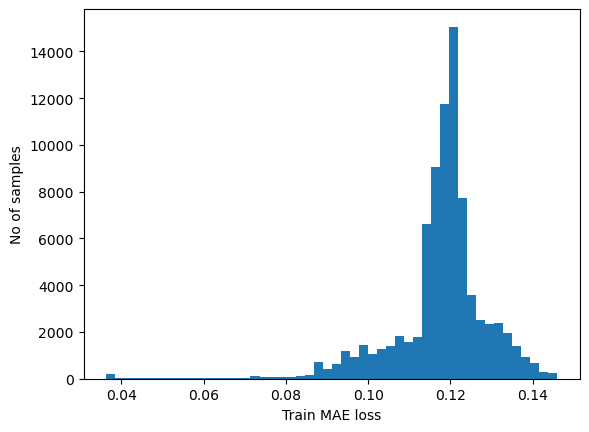

In [32]:
# Get train MAE loss.
x_train_pred = model.predict(X)
train_mae_loss = np.mean(np.abs(x_train_pred - X), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [24]:
te_ind=np.random.randint(0,41000,10000)
X_te=X[te_ind]

313/313 [==============================] - 1s 2ms/step
Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


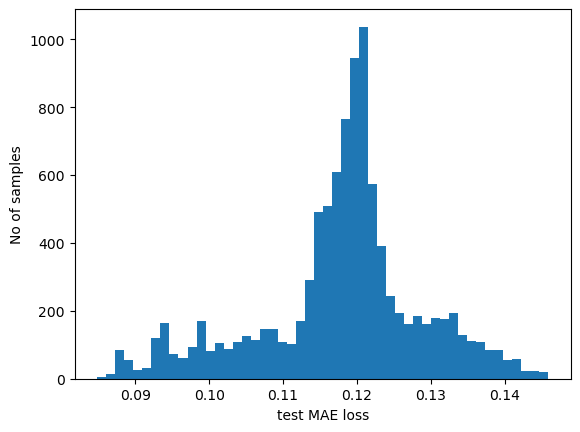

In [33]:
# Get test MAE loss.
x_test_pred = model.predict(X_te)
test_mae_loss = np.mean(np.abs(x_test_pred - X_te), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [83]:
import matplotlib.pyplot as plt

In [101]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 50, 32)            256       
                                                                 
 dropout_6 (Dropout)         (None, 50, 32)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 25, 16)            3600      
                                                                 
 conv1d_transpose_9 (Conv1D  (None, 50, 16)            1808      
 Transpose)                                                      
                                                                 
 dropout_7 (Dropout)         (None, 50, 16)            0         
                                                                 
 conv1d_transpose_10 (Conv1  (None, 100, 32)           3616      
 DTranspose)                                          

In [102]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
1/1 [==============================] - 0s 433ms/step - loss: 0.8444 - val_loss: 0.4924
Epoch 2/50
1/1 [==============================] - 0s 16ms/step - loss: 0.8260 - val_loss: 0.4859
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 0.8129 - val_loss: 0.4797
Epoch 4/50
1/1 [==============================] - 0s 15ms/step - loss: 0.7942 - val_loss: 0.4733
Epoch 5/50
1/1 [==============================] - 0s 14ms/step - loss: 0.7785 - val_loss: 0.4667
Epoch 6/50
1/1 [==============================] - 0s 14ms/step - loss: 0.7577 - val_loss: 0.4598
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 0.7392 - val_loss: 0.4525
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 0.7170 - val_loss: 0.4445
Epoch 9/50
1/1 [==============================] - 0s 15ms/step - loss: 0.6973 - val_loss: 0.4354
Epoch 10/50
1/1 [==============================] - 0s 14ms/step - loss: 0.6765 - val_loss: 0.4248
Epoch 11/50
1/1 [===========

In [305]:
#structure data: take first t timestamps
def restructure(arr,kernel,window):
    l=[]
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i]
        for j in np.unique(dub[:,1]):
            sub=MinMaxScaler().fit_transform(dub[dub[:,1]==j])
            if len(sub)>5000 and len(sub)<8000:
                #ind=np.linspace(0,len(sub),5001).astype(int)[:-1]
                for k in range(kernel):
                    l.append(sub[k:k+window,2:])
    if len(l)>1:
        X=np.stack(l)
    else:
        X=np.array(l)
    X=X.reshape(X.shape[0],X.shape[1],28)
    return X

In [306]:
X=restructure(X_c,kernel=500,window=100)

In [52]:
#build model- filters for how many unique can be pulled layer to layer; kernel for specificity
model = keras.Sequential(
    [
        layers.Input(shape=(X.shape[1], X.shape[2])),
        layers.Conv1D(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=20,
            kernel_size=8,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=10, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")

In [53]:
#fit model
history = model.fit(
    X,
    X,
    epochs=10,
    batch_size=300,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/10
110/110 [==============================] - 2s 14ms/step - loss: 0.2187 - val_loss: 0.1536
Epoch 2/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1038 - val_loss: 0.1731
Epoch 3/10
110/110 [==============================] - 1s 13ms/step - loss: 0.0997 - val_loss: 0.1755
Epoch 4/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0976 - val_loss: 0.1555
Epoch 5/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0944 - val_loss: 0.1554
Epoch 6/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0943 - val_loss: 0.1561
Epoch 7/10
110/110 [==============================] - 1s 13ms/step - loss: 0.0936 - val_loss: 0.1331
Epoch 8/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0925 - val_loss: 0.1253
Epoch 9/10
110/110 [==============================] - 1s 13ms/step - loss: 0.0924 - val_loss: 0.1344
Epoch 10/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0912 - val_lo

In [54]:
# Get train loss.
def train_loss(X):
    x_train_pred = model.predict(X)
    train_mae_loss = np.mean(np.abs(x_train_pred - X), axis=1)
    threshold = np.max(train_mae_loss)
    return threshold

In [55]:
threshold=train_loss(X) #this would be the chance to modify threshold

1282/1282 [==============================] - 1s 887us/step


In [72]:
def run_diagnostic(test_point,threshold):
    x_test_pred = model.predict(test_point)
    test_mae_loss = np.mean(np.abs(x_test_pred - test_point))
    if test_mae_loss>threshold:
        result=str('Alert!')
    else:
        result=str('Pull Chocks')
    return result

In [304]:
test_point=restructure(X_c[:7000],kernel=1000,window=100)


(1000, 100, 28)


In [73]:
run_diagnostic(test_point=test_point,threshold=threshold)

16/16 [==============================] - 0s 1ms/step


'Pull Chocks'

In [76]:
last_flights=[]
for i in np.unique(X_c[:,0]):
    dub=X_c[X_c[:,0]==i]
    last_flights.append(dub[dub[:,1]==np.max(dub[:,1])])   
    

In [78]:
len(last_flights)

9

In [168]:
#structure data for single flight
def restructure_flight(arr,kernel,window):
    l=[]
    sub=MinMaxScaler().fit_transform(arr)
    if len(sub)>5000 and len(sub)<15000:
        #ind=np.linspace(0,len(sub),5001).astype(int)[:-1]
        for k in range(kernel):
            l.append(sub[k:k+window,2:])
    if len(l)>1:
        X=np.stack(l)
        X=X.reshape(X.shape[0],X.shape[1],28)
        return X
    else:
        pass


In [246]:
test_points=[]
ruls=[]
degs=[]
n=0
dub=X_c[X_c[:,0]==18.0]
N=len(dub)
for j in np.unique(dub[:,1]):
    sub=dub[dub[:,1]==j]
    t_b=T[n,6]
    n+=len(sub)
    t_e=T[n,6]
    if sub.shape[0]>5000 and sub.shape[0]<15000:
        flt=restructure_flight(sub,kernel=500,window=100)
        test_points.append(flt)
        ruls.append(N-n)
        degs.append(t_e-t_b)
    else:
        pass
    #test_points=np.stack(test_points)
    #test_points=test_points.reshape(test_points.shape[1],test_points.shape[2],test_points.shape[3])

In [247]:
test_points=np.stack(test_points)

In [248]:
test_points.shape

(64, 500, 100, 28)

In [249]:
#let's try a batched run to see how we do
def run_grouped_diagnostic(test_points,ruls,threshold):
    #test_points=restructure(array,kernel,window)
    life_rem_fault=[]
    life_rem_good=[]
    faults=[]
    goods=[]
    for i,test_point in enumerate(test_points):
        x_test_pred=model.predict(test_point)
        test_mae_loss = np.mean(np.abs(x_test_pred - test_point))
        if test_mae_loss>threshold:
            faults.append(test_mae_loss)
            life_rem_fault.append(ruls[i])
        else:
            goods.append(test_mae_loss)
            life_rem_good.append(ruls[i])
    return faults,goods,life_rem_fault,life_rem_good

In [295]:
f,g,lf,lg=run_grouped_diagnostic(test_points,ruls,threshold=0.6)

16/16 [==============================] - 0s 931us/step


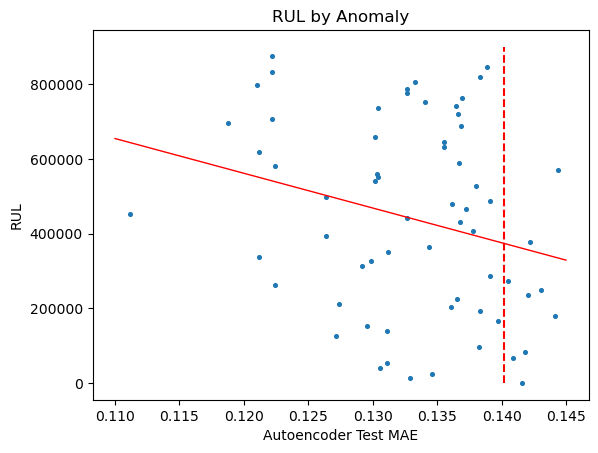

In [296]:
plt.scatter(g,lg,s=7)
plt.scatter(f,lf,s=7)
plt.vlines(x=0.1402,ymin=0,ymax=900000,linestyles='dashed',colors='red')
plt.xlabel('Autoencoder Test MAE')
plt.ylabel('RUL')
plt.title('RUL by Anomaly')
b, a = np.polyfit(g, lg, deg=1)
# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0.110, 0.145, num=100)

# Plot regression line
plt.plot(xseq, a + b * xseq, color="red", lw=1.0)
#plt.scatter(f,lf,s=7)
#at first glance doesn't appear to be anything to go off of here

In [114]:
#structure data: take first t timestamps
def restructure(arr,kernel,window):
    l=[]
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i]
        for j in np.unique(dub[:,1]):
            sub=MinMaxScaler().fit_transform(dub[dub[:,1]==j])
            if len(sub)>5000 and len(sub)<8000:
                #ind=np.linspace(0,len(sub),5001).astype(int)[:-1]
                for k in range(kernel):
                    l.append(sub[k:k+window,2:])
    if len(l)>1:
        X=np.stack(l)
    else:
        X=np.array(l)
    print(X.shape)
    X=X.reshape(X.shape[0],X.shape[1],28)
    return X